In [1]:
import numpy as np 
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import math
from os import listdir
from skimage import novice
from scipy.misc import imshow
from scipy.ndimage import rotate
import scipy
from os import mkdir

In [2]:
d_images = list()
u_images = list()
p_images = list()
for image in listdir('full_dataset/d'):
    d_images.append('full_dataset/d/'+image)
for image in listdir('full_dataset/u'):
    u_images.append('full_dataset/u/'+image)
for image in listdir('full_dataset/p'):
    p_images.append('full_dataset/p/'+image)
data = np.ndarray([1986,96*96*3])
i = 0
for image in d_images:
    raw = novice.open(image)
    raw.size = (96,96)
    data[i] = raw.rgb.reshape([96*96*3])
    i = i+1
for image in u_images:
    raw = novice.open(image)
    raw.size = (96,96)
    data[i] = raw.rgb.reshape([96*96*3])
    i = i+1
for image in p_images:
    raw = novice.open(image)
    raw.size = (96,96)
    data[i] = raw.rgb.reshape([96*96*3])
    i = i+1
data = np.hstack([data, np.zeros([1986,1])])
for i in range(1372,1774):
    data[i][27648]=1
for i in range(1774,1986):
    data[i][27648]=2

np.random.shuffle(data)
train_data = data[0:1500,0:27649]
test_data = data[1500:1986,0:27649]

/usr/lib/python2.7/dist-packages/skimage/util/dtype.py:107: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [3]:
tf.reset_default_graph()

keep_prob = tf.placeholder("float")
x = tf.placeholder(tf.float32, shape=[None, 27648])
y = tf.placeholder(tf.float32, shape=[None, 3])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1, 96, 96, 3])
W_conv1 = weight_variable([7, 7, 3, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_conv3 = weight_variable([5, 5, 64, 128])
b_conv3 = bias_variable([128])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

W_conv3 = weight_variable([5, 5, 64, 128])
b_conv3 = bias_variable([128])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

h_pool3_flat = tf.reshape(h_pool3, [-1, 12*12*128])
W_fc1 = weight_variable([12 * 12 * 128, 512])
b_fc1 = bias_variable([512])

h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

W_fc2 = weight_variable([512, 512])
b_fc2 = bias_variable([512])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

keep_prob = tf.placeholder(tf.float32)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

W_fc3 = weight_variable([512, 3])
b_fc3 = bias_variable([3])

y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

test_images=test_data[0:486,0:27648]
test_labels=np.zeros((486,3))
test_labels[np.arange(486), np.reshape(test_data[0:486,27648:27649].astype(int),[486])]=1

In [17]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,27648],order='F'),keep_prob:1.0})
    plotNNFilter(units)
def plotNNFilter(units):
    print(units.shape[3])
    filters = units.shape[3]
    plt.figure(1, figsize=(22,22))
    n_columns = 6
    if filters==64:
        n_columns=9
    if filters==128:
        n_columns=12
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i+1))
        plt.imshow(rotate(units[0,:,:,i],90))
def saveActivations(layer,stimuli,path):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,27648],order='F'),keep_prob:1.0})
    filters = units.shape[3]
    for i in range(filters):
        scipy.misc.imsave(path+'/filter_'+str(i+1)+'.jpg', rotate(units[0,:,:,i],90))

In [5]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for j in range(100):
    np.random.shuffle(train_data)
    train_images=train_data[0:1500,0:27648]
    train_labels=np.zeros((1500,3))
    train_labels[np.arange(1500), np.reshape(train_data[0:1500,27648:27649].astype(int),[1500])]=1
    print 'Epoch '+str(j)
    for i in range(30):
        sess.run(train_step, feed_dict={x: train_images[(i*50):(i*50)+50,0:], y: train_labels[(i*50):(i*50)+50,0:], keep_prob: 1.0})
        if (i+1) % 1 == 0:
            trainAccuracy = sess.run(accuracy, feed_dict={x: train_images[(i*50):(i*50)+50,0:], y: train_labels[(i*50):(i*50)+50,0:], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i+1, trainAccuracy))
    print('%d epoch test accuracy %g' % (j,sess.run(accuracy,feed_dict={x: test_images, y: test_labels, keep_prob: 1.0})))

Epoch 0
step 1, training accuracy 0.34
step 2, training accuracy 0.52
step 3, training accuracy 0.62
step 4, training accuracy 0.82
step 5, training accuracy 0.74
step 6, training accuracy 0.84
step 7, training accuracy 0.74
step 8, training accuracy 0.76
step 9, training accuracy 0.7
step 10, training accuracy 0.8
step 11, training accuracy 0.82
step 12, training accuracy 0.86
step 13, training accuracy 0.8
step 14, training accuracy 0.78
step 15, training accuracy 0.84
step 16, training accuracy 0.78
step 17, training accuracy 0.78
step 18, training accuracy 0.86
step 19, training accuracy 0.86
step 20, training accuracy 0.78
step 21, training accuracy 0.78
step 22, training accuracy 0.72
step 23, training accuracy 0.84
step 24, training accuracy 0.84
step 25, training accuracy 0.76
step 26, training accuracy 0.74
step 27, training accuracy 0.86
step 28, training accuracy 0.86
step 29, training accuracy 0.88
step 30, training accuracy 0.8
0 epoch test accuracy 0.8107
Epoch 1
step 1, 

step 14, training accuracy 1
step 15, training accuracy 0.98
step 16, training accuracy 0.96
step 17, training accuracy 0.98
step 18, training accuracy 1
step 19, training accuracy 0.92
step 20, training accuracy 0.98
step 21, training accuracy 1
step 22, training accuracy 0.98
step 23, training accuracy 0.84
step 24, training accuracy 0.96
step 25, training accuracy 1
step 26, training accuracy 0.94
step 27, training accuracy 0.98
step 28, training accuracy 0.92
step 29, training accuracy 0.96
step 30, training accuracy 0.98
8 epoch test accuracy 0.882716
Epoch 9
step 1, training accuracy 0.94
step 2, training accuracy 0.98
step 3, training accuracy 1
step 4, training accuracy 1
step 5, training accuracy 0.94
step 6, training accuracy 0.98
step 7, training accuracy 0.96
step 8, training accuracy 1
step 9, training accuracy 0.98
step 10, training accuracy 0.96
step 11, training accuracy 0.96
step 12, training accuracy 1
step 13, training accuracy 1
step 14, training accuracy 1
step 15,

step 5, training accuracy 1
step 6, training accuracy 1
step 7, training accuracy 1
step 8, training accuracy 0.98
step 9, training accuracy 1
step 10, training accuracy 0.96
step 11, training accuracy 1
step 12, training accuracy 1
step 13, training accuracy 1
step 14, training accuracy 1
step 15, training accuracy 1
step 16, training accuracy 1
step 17, training accuracy 0.94
step 18, training accuracy 0.98
step 19, training accuracy 1
step 20, training accuracy 1
step 21, training accuracy 1
step 22, training accuracy 0.94
step 23, training accuracy 0.98
step 24, training accuracy 1
step 25, training accuracy 1
step 26, training accuracy 1
step 27, training accuracy 1
step 28, training accuracy 0.96
step 29, training accuracy 1
step 30, training accuracy 1
17 epoch test accuracy 0.86214
Epoch 18
step 1, training accuracy 0.98
step 2, training accuracy 1
step 3, training accuracy 1
step 4, training accuracy 1
step 5, training accuracy 0.98
step 6, training accuracy 1
step 7, training

step 29, training accuracy 0.94
step 30, training accuracy 0.98
25 epoch test accuracy 0.86214
Epoch 26
step 1, training accuracy 0.98
step 2, training accuracy 1
step 3, training accuracy 1
step 4, training accuracy 1
step 5, training accuracy 1
step 6, training accuracy 1
step 7, training accuracy 1
step 8, training accuracy 1
step 9, training accuracy 1
step 10, training accuracy 1
step 11, training accuracy 1
step 12, training accuracy 1
step 13, training accuracy 1
step 14, training accuracy 1
step 15, training accuracy 1
step 16, training accuracy 1
step 17, training accuracy 1
step 18, training accuracy 1
step 19, training accuracy 1
step 20, training accuracy 1
step 21, training accuracy 1
step 22, training accuracy 1
step 23, training accuracy 1
step 24, training accuracy 1
step 25, training accuracy 1
step 26, training accuracy 1
step 27, training accuracy 0.98
step 28, training accuracy 1
step 29, training accuracy 1
step 30, training accuracy 1
26 epoch test accuracy 0.8847

step 30, training accuracy 1
34 epoch test accuracy 0.858025
Epoch 35
step 1, training accuracy 1
step 2, training accuracy 1
step 3, training accuracy 1
step 4, training accuracy 1
step 5, training accuracy 1
step 6, training accuracy 1
step 7, training accuracy 1
step 8, training accuracy 1
step 9, training accuracy 1
step 10, training accuracy 1
step 11, training accuracy 1
step 12, training accuracy 1
step 13, training accuracy 1
step 14, training accuracy 1
step 15, training accuracy 1
step 16, training accuracy 1
step 17, training accuracy 1
step 18, training accuracy 1
step 19, training accuracy 1
step 20, training accuracy 1
step 21, training accuracy 1
step 22, training accuracy 1
step 23, training accuracy 1
step 24, training accuracy 1
step 25, training accuracy 1
step 26, training accuracy 1
step 27, training accuracy 1
step 28, training accuracy 1
step 29, training accuracy 1
step 30, training accuracy 1
35 epoch test accuracy 0.886831
Epoch 36
step 1, training accuracy 1


step 1, training accuracy 1
step 2, training accuracy 1
step 3, training accuracy 1
step 4, training accuracy 1
step 5, training accuracy 1
step 6, training accuracy 1
step 7, training accuracy 1
step 8, training accuracy 1
step 9, training accuracy 1
step 10, training accuracy 1
step 11, training accuracy 1
step 12, training accuracy 1
step 13, training accuracy 1
step 14, training accuracy 1
step 15, training accuracy 1
step 16, training accuracy 1
step 17, training accuracy 1
step 18, training accuracy 1
step 19, training accuracy 1
step 20, training accuracy 1
step 21, training accuracy 1
step 22, training accuracy 1
step 23, training accuracy 1
step 24, training accuracy 1
step 25, training accuracy 1
step 26, training accuracy 1
step 27, training accuracy 1
step 28, training accuracy 1
step 29, training accuracy 1
step 30, training accuracy 1
44 epoch test accuracy 0.860082
Epoch 45
step 1, training accuracy 1
step 2, training accuracy 1
step 3, training accuracy 1
step 4, traini

step 4, training accuracy 1
step 5, training accuracy 1
step 6, training accuracy 1
step 7, training accuracy 1
step 8, training accuracy 1
step 9, training accuracy 1
step 10, training accuracy 1
step 11, training accuracy 1
step 12, training accuracy 1
step 13, training accuracy 1
step 14, training accuracy 1
step 15, training accuracy 1
step 16, training accuracy 1
step 17, training accuracy 1
step 18, training accuracy 1
step 19, training accuracy 1
step 20, training accuracy 1
step 21, training accuracy 1
step 22, training accuracy 1
step 23, training accuracy 1
step 24, training accuracy 1
step 25, training accuracy 1
step 26, training accuracy 1
step 27, training accuracy 1
step 28, training accuracy 1
step 29, training accuracy 1
step 30, training accuracy 1
53 epoch test accuracy 0.874486
Epoch 54
step 1, training accuracy 1
step 2, training accuracy 1
step 3, training accuracy 1
step 4, training accuracy 1
step 5, training accuracy 1
step 6, training accuracy 1
step 7, traini

step 7, training accuracy 1
step 8, training accuracy 1
step 9, training accuracy 1
step 10, training accuracy 1
step 11, training accuracy 1
step 12, training accuracy 1
step 13, training accuracy 1
step 14, training accuracy 1
step 15, training accuracy 1
step 16, training accuracy 1
step 17, training accuracy 1
step 18, training accuracy 1
step 19, training accuracy 1
step 20, training accuracy 1
step 21, training accuracy 1
step 22, training accuracy 1
step 23, training accuracy 1
step 24, training accuracy 1
step 25, training accuracy 1
step 26, training accuracy 1
step 27, training accuracy 1
step 28, training accuracy 1
step 29, training accuracy 1
step 30, training accuracy 1
62 epoch test accuracy 0.874486
Epoch 63


KeyboardInterrupt: 

In [6]:
testAccuracy = sess.run(accuracy, feed_dict={x: test_images, y: test_labels, keep_prob:1.0})
print("final test accuracy %g"%(testAccuracy))

final test accuracy 0.874486


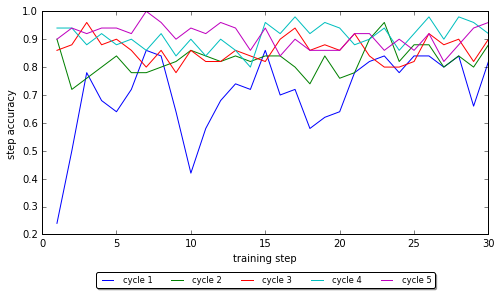

In [57]:
from matplotlib.font_manager import FontProperties
fontP=FontProperties()
fontP.set_size("small")
plt.figure(1, figsize=(8,4))
#print c[0].shape
plt.plot(range(1,31), c[0],label="cycle 1")
plt.plot(range(1,31), c[1],label="cycle 2")
plt.plot(range(1,31), c[2],label="cycle 3")
plt.plot(range(1,31), c[3],label="cycle 4")
plt.plot(range(1,31), c[4],label="cycle 5")
plt.ylabel('step accuracy')
plt.xlabel('training step')
plt.legend(loc='upper center',bbox_to_anchor=(0.5,-0.15),fancybox=True,shadow=True,ncol=5,prop=fontP)
plt.show()

correct label :  undisguised
predicted label :  undisguised


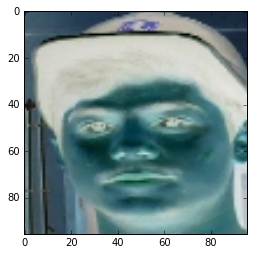

In [39]:
index = 8
imageToUse = test_images[index]
y_correct = test_labels[index]
plt.imshow(rotate(np.reshape(imageToUse,[96,96,3]),90))
imshow(rotate(np.reshape(imageToUse,[96,96,3]),90))
y_predict = sess.run(y_conv,feed_dict={x:np.reshape(imageToUse,[1,27648],order='F'),keep_prob:1.0})[0]
max_p=0
max_c=0
for i in range(1,3):
    if y_predict[max_p]<y_predict[i]:
        max_p=i
    if y_correct[max_c]<y_correct[i]:
        max_c=i
labels={0:"disguised", 1:"undisguised", 2:"partially disguised"}
print "correct label : ", labels[max_c]
print "predicted label : ", labels[max_p]

32


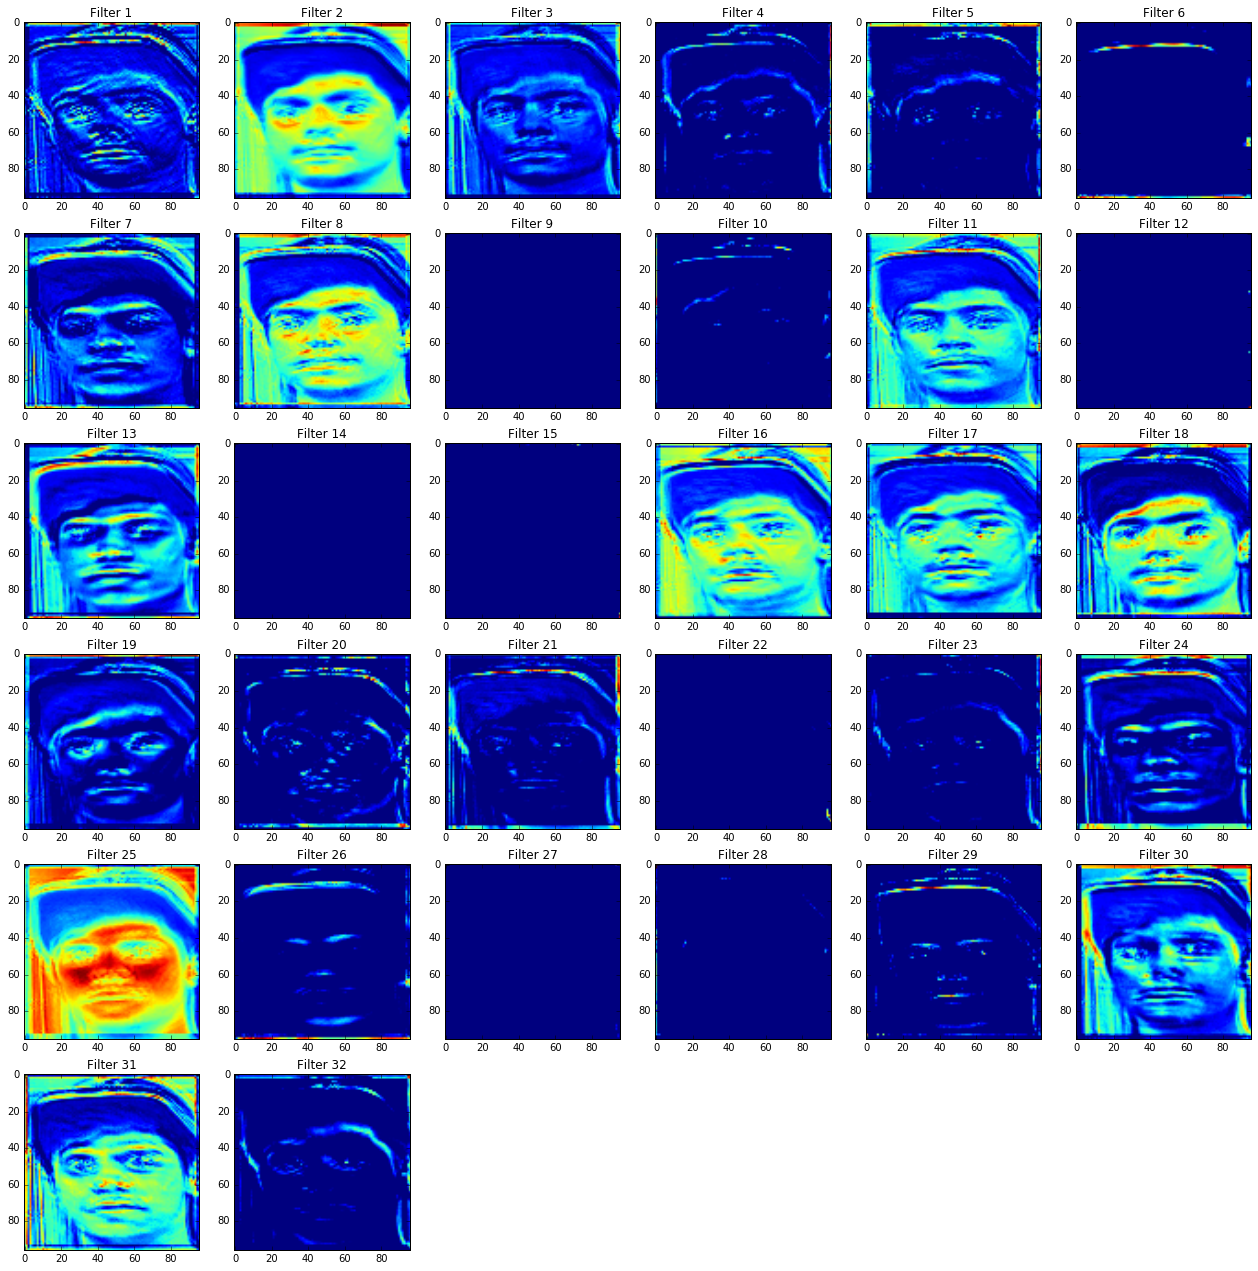

In [36]:
getActivations(h_conv1,imageToUse)

64


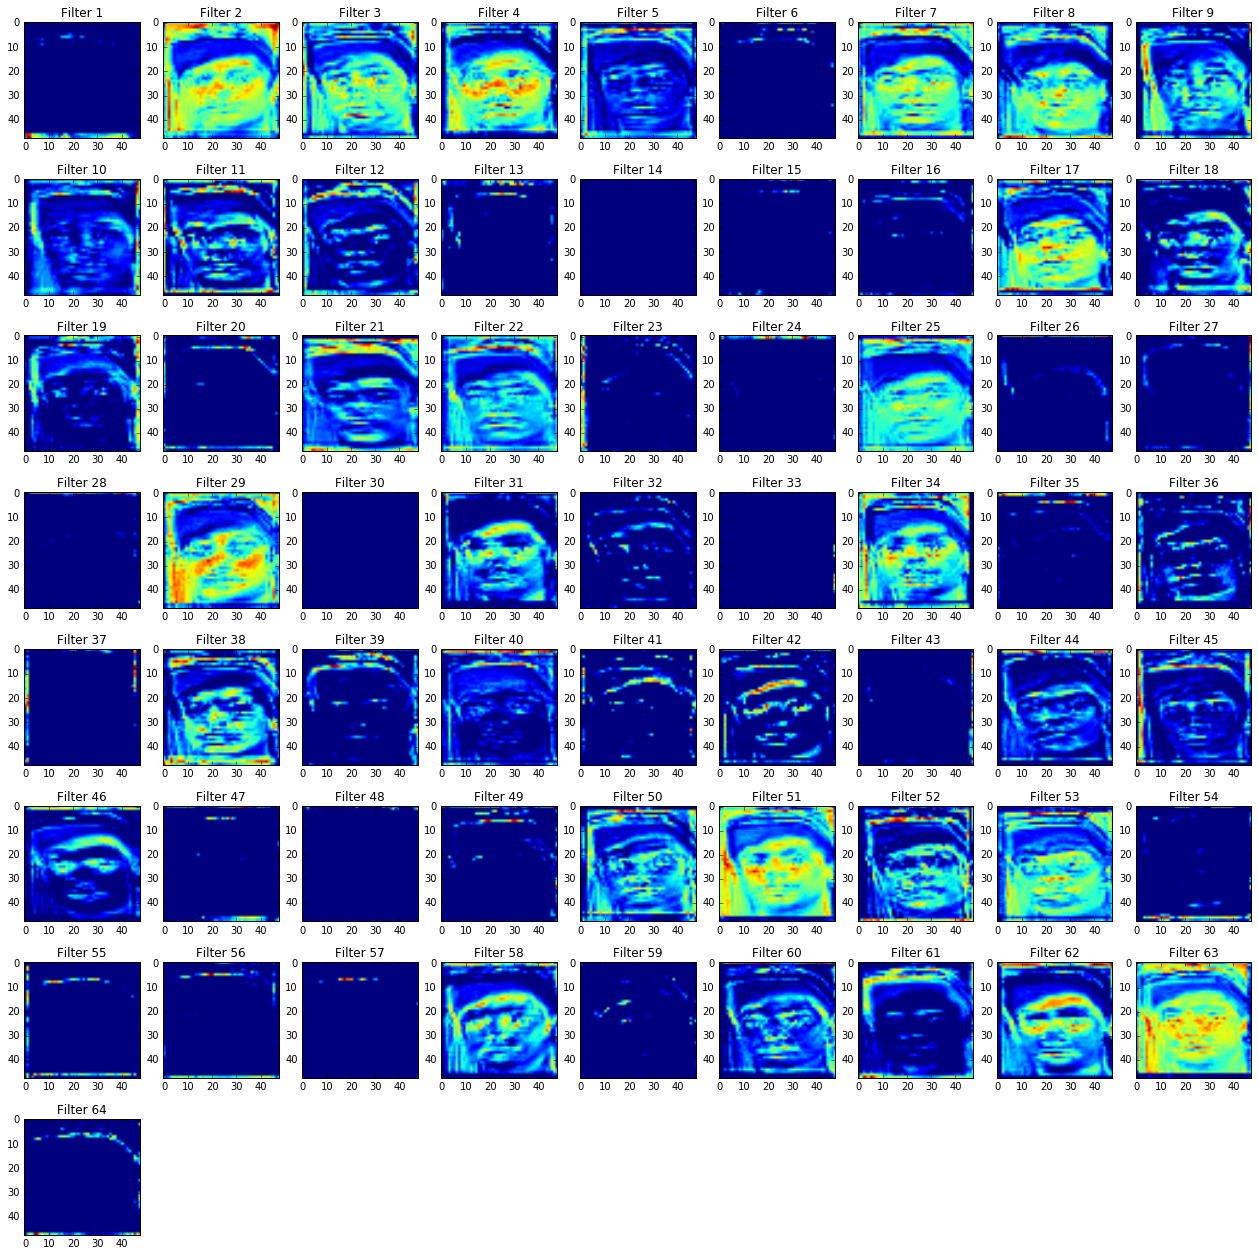

In [37]:
getActivations(h_conv2,imageToUse)

128


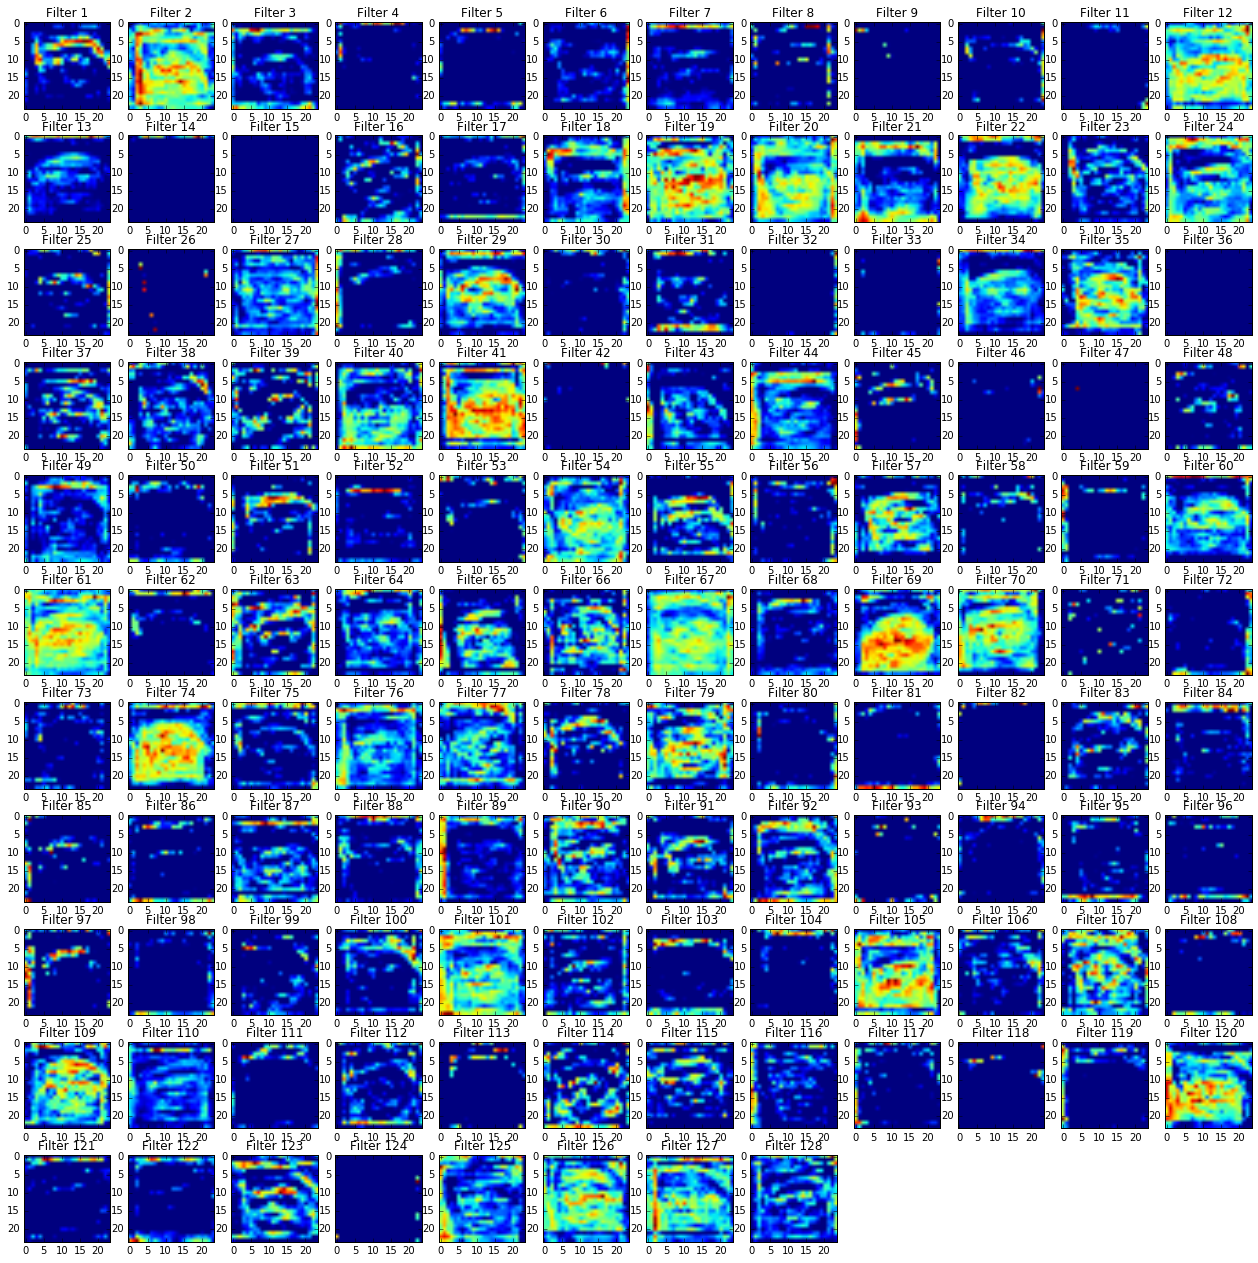

In [38]:
getActivations(h_conv3,imageToUse)